In [2]:
import os
from dotenv import load_dotenv
from pathlib import Path

NOTEBOOK_PATH = Path().resolve()
dotenv_path = NOTEBOOK_PATH.parent / "postgres.env"
load_dotenv(dotenv_path)

DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBUSER = os.environ.get("DBUSER")
DBNAME = os.environ.get("DBNAME")
DBPASS = os.environ.get("DBPASS")

In [3]:
from sqlalchemy import create_engine, URL

engine_url = URL.create(
    drivername="postgresql+psycopg2",
    username=DBUSER,
    password=DBPASS,
    host=DBHOST,
    port=DBPORT,
    database=DBNAME,
)

engine = create_engine(url=engine_url)

In [4]:
import geopandas as gpd

ph_shp = gpd.read_file(
    NOTEBOOK_PATH.parent / 
    "raw_files" / 
    "Shapefile" / 
    "PH_Adm2_ProvDists.shp.zip",
    crs="EPSG:4326"
)

In [5]:
import numpy as np
from shapely.geometry import Polygon

minx, miny, maxx, maxy = ph_shp.total_bounds

grid_space = 0.05

grid_lon = list(np.arange(minx, maxx+grid_space, grid_space))
grid_lat = list(np.arange(miny, maxy+grid_space, grid_space))

polygons = []
for lon in grid_lon[:-1]:
    for lat in grid_lat[:-1]:
        polygons.append(Polygon([(lon, lat), 
                                 (lon+grid_space, lat),
                                 (lon+grid_space, lat+grid_space),
                                 (lon, lat+grid_space),
                                 ]
                                )
                        )

square_grid = gpd.GeoDataFrame(
        geometry=polygons,
        crs="EPSG:4326"
    )

<Axes: >

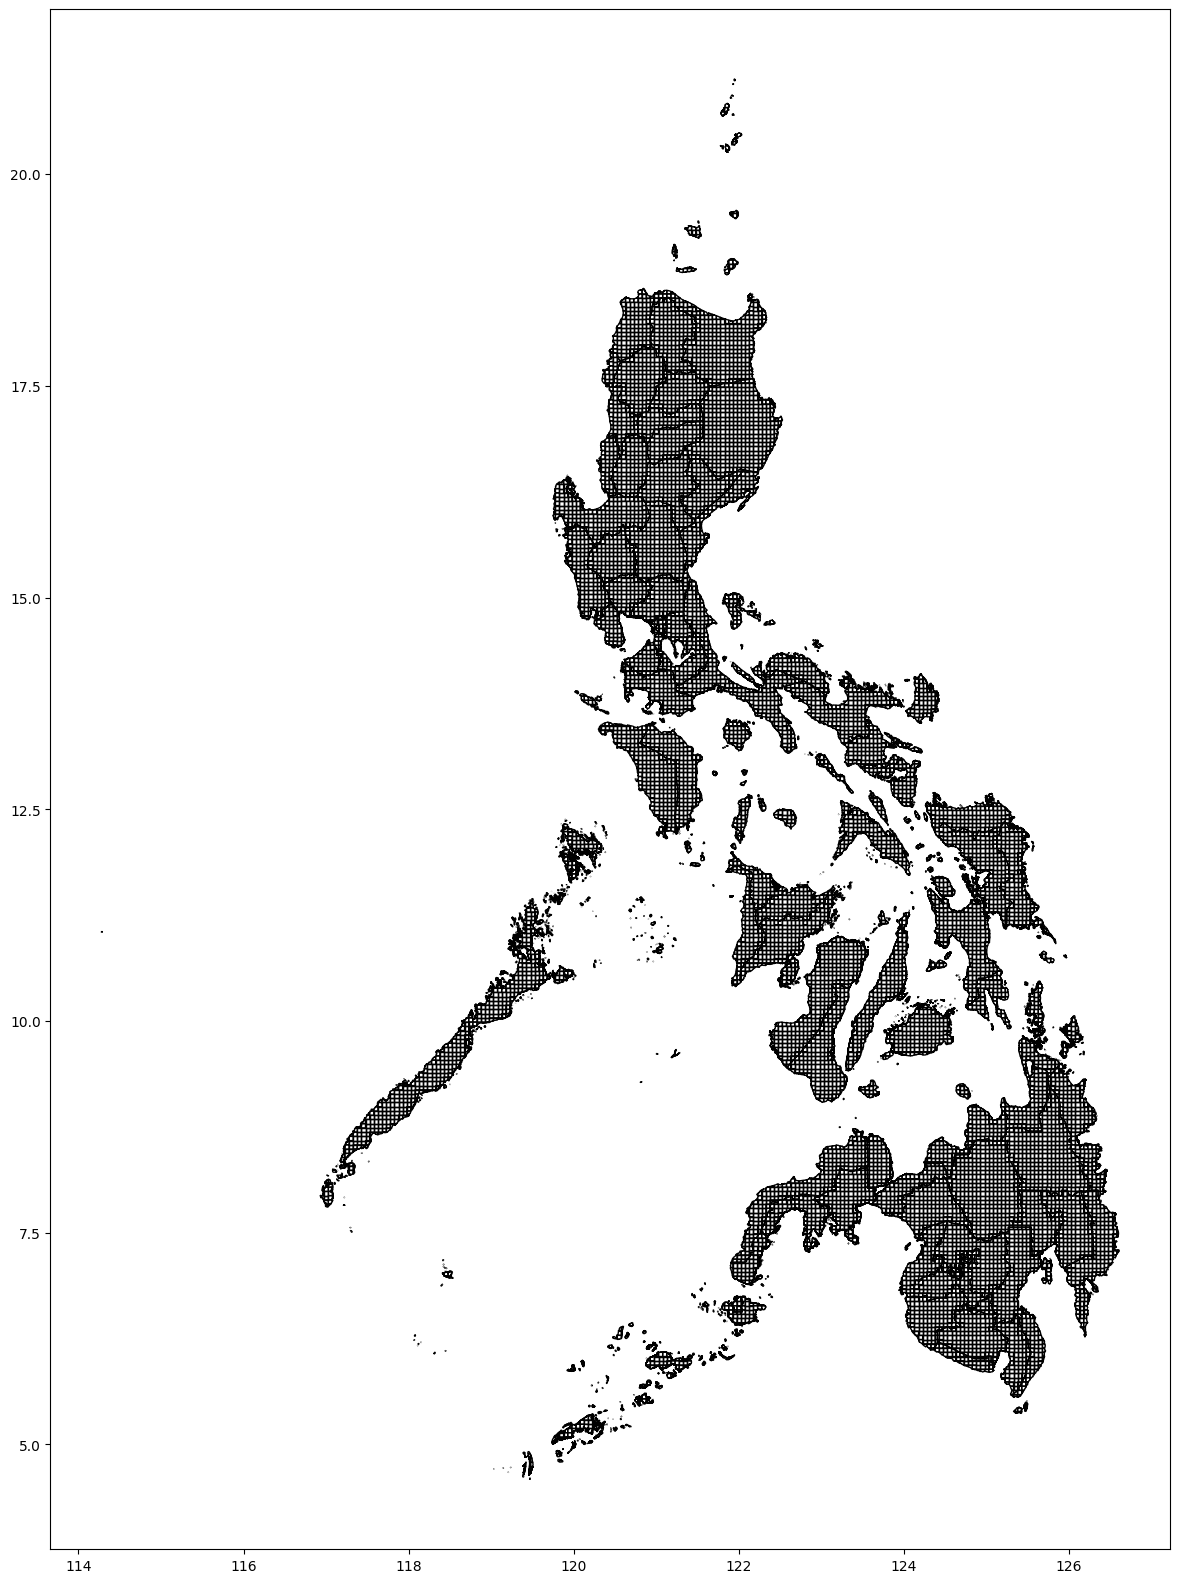

In [6]:
intersection = square_grid.overlay(ph_shp, how="intersection")
intersection = intersection[["geometry"]]
intersection.plot(figsize=(20,20), facecolor="None", edgecolor="black")

In [13]:
intersection.to_postgis(
    name="grid_shp",
    con=engine,
    if_exists="replace",
)